# 📊🧪 Literature Screening – Multi‑class Model Evaluation
Aggregate results for **train** and **test** splits, report core metrics for the binary *Included vs Excluded* task, then evaluate the extra fields returned *only* for items predicted as **Included**.

We focus on the structured fields that are straightforward to score:
* **domain** → matches column **Social, Behavioural or Implementation Science?**
* **dmf_stage** → matches column **DMF - Identify the issue and its context, assess risks and benefits, identify and analyze options, select a strategy, implement the strategy, monitor and evaluate results, involve interested and affected parties**
* **decision_type** → matches column **DMF - Are the decisions regulatory, policy, or other? Please describe the “other” if applicable.**  
  For **decision_type** a prediction that *contains* the word **other** is considered correct when the ground‑truth field also contains **other** (ignoring any free‑text description).

In [1]:
# ╔════════════════════════════════════════════════╗
# ║ Cell 1 – Imports and helpers 🔌                ║
# ╚════════════════════════════════════════════════╝
import json
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

sns.set(style="whitegrid")


In [2]:
# ╔════════════════════════════════════════════════╗
# ║ Cell 2 – Locate outputs and datasets 🔍         ║
# ╚════════════════════════════════════════════════╝
notebook_dir = Path(__file__).parent if "__file__" in globals() else Path.cwd()
root_dir      = notebook_dir  # all_class_files/
outputs_root  = root_dir / "outputs"
datasets_dir  = root_dir.parent / "datasets"

if not outputs_root.exists():
    raise RuntimeError(f"Could not find outputs directory at: {outputs_root}")
if not datasets_dir.exists():
    raise RuntimeError(f"Could not find datasets directory at: {datasets_dir}")

# every sub‑folder inside outputs/ is a model name
model_dirs = [d for d in outputs_root.iterdir() if d.is_dir() and d.name != "datasets"]
if not model_dirs:
    raise RuntimeError(f"No model result folders found inside '{outputs_root}/'")

print("Models found:", ", ".join(d.name for d in model_dirs))

Models found: gpt-4.1, gpt-4o, o3


In [3]:
# ╔════════════════════════════════════════════════╗
# ║ Cell 2.5 – Load and clean ground-truth data 🗄️ ║
# ╚════════════════════════════════════════════════╝

def load_ground_truth(split: str) -> pd.DataFrame:
    """
    Loads and cleans ground-truth data for a given split.
    Returns a DataFrame with cleaned columns.
    """
    if split not in ["train", "test"]:
        raise ValueError(f"Invalid split: {split}. Must be either 'train' or 'test'")
    
    # load ground-truth data
    csv_path = datasets_dir / f"{split}_dataset.csv"
    if not csv_path.exists():
        raise FileNotFoundError(csv_path)
    df_t = pd.read_csv(csv_path)
    truth_cols = {
        "id": "id",
        "label": "ground_truth",
        "Social, Behavioural or Implementation Science?": "domain_gt",
        "DMF - Identify the issue and its context, assess risks and benefits, identify and analyze options, select a strategy, implement the strategy, monitor and evaluate results, involve interested and affected parties": "dmf_stage_gt",
        "DMF - Are the decisions regulatory, policy, or other? Please describe the “other” if applicable.": "decision_type_gt",
        "IS - Does your submission include or intersect with Black, Indigenous or racialized groups?": "bipoc_gt",
        "IS - Does your submission include or intersect with Indigenous Peoples?": "indigenous_gt",
        "IS - Have you included Sex in your study:": "sex_gt",
        "IS - Have you included Gender in your study?": "gender_gt",
        "IS - Have you considered identity factors other than sex and gender?": "identity_factors_gt",
    }
    df_t = df_t.rename(columns=truth_cols)[list(truth_cols.values())]

    # clean ground-truth data

    for col in ["ground_truth", "domain_gt", "dmf_stage_gt", "decision_type_gt", "bipoc_gt", "indigenous_gt", "sex_gt", "gender_gt", "identity_factors_gt"]:
        df_t[col] = df_t[col].apply(lambda x: x.strip().lower() if isinstance(x, str) else "")

    allowed_labels = ["included", "excluded"]
    df_t.loc[~df_t["ground_truth"].isin(allowed_labels), "ground_truth"] = None

    allowed_domains = ["social", "behavioural", "implementation"]
    df_t.loc[~df_t["domain_gt"].isin(allowed_domains), "domain_gt"] = None
        
    allowed_stages = ["identify the issue and its context", "assess risks and benefits", "identify and analyze options", "select a strategy", "implement the strategy", "monitor and evaluate results", "involve interested and affected parties"]
    df_t.loc[~df_t["dmf_stage_gt"].isin(allowed_stages), "dmf_stage_gt"] = None

    allowed_decision_types = ["regulatory", "policy", "other"]        
    df_t.loc[df_t["decision_type_gt"].str.contains("other"), "decision_type_gt"] = "other"
    df_t.loc[~df_t["decision_type_gt"].isin(allowed_decision_types), "decision_type_gt"] = None

    allowed_identity = ["yes", "not reported"]       
    for col in ["bipoc_gt", "indigenous_gt", "sex_gt", "gender_gt"]:
        df_t.loc[df_t[col].str.contains("yes"), col] = "yes"
        df_t.loc[~df_t[col].isin(allowed_identity), col] = None

    return df_t

# Load ground-truth data for both splits
df_train = load_ground_truth("train")
df_test = load_ground_truth("test")


In [4]:
# ╔═════════════════════════════════════════╗
# ║ Cell 2.7 – Explore ground-truth data 🗄️ ║
# ╚═════════════════════════════════════════╝

# Look at the distribution of ground-truth labels in the training set.
print(f"There are {len(df_train)} rows in the training set.")

for col in ["ground_truth", "domain_gt", "dmf_stage_gt", "decision_type_gt", "bipoc_gt", "indigenous_gt", "sex_gt", "gender_gt"]:
    counts = df_train[col].value_counts(dropna=False)
    counts_norm = df_train[col].value_counts(normalize=True) * 100
    None_count = counts.get(None, 0)
    print(f"\nThere are {None_count} None elements in the {col} column.")
    print(f"If we ignore None elements, the labels in {col} are distributed as follows:")
    print(counts_norm.rename_axis(None).rename(None).map(lambda x: f"{x:.1f}%").to_string())


There are 521 rows in the training set.

There are 0 None elements in the ground_truth column.
If we ignore None elements, the labels in ground_truth are distributed as follows:
included    50.1%
excluded    49.9%

There are 264 None elements in the domain_gt column.
If we ignore None elements, the labels in domain_gt are distributed as follows:
behavioural       59.5%
social            36.6%
implementation     3.9%

There are 263 None elements in the dmf_stage_gt column.
If we ignore None elements, the labels in dmf_stage_gt are distributed as follows:
assess risks and benefits                  48.4%
identify and analyze options               25.2%
monitor and evaluate results               10.9%
identify the issue and its context          8.9%
implement the strategy                      3.5%
involve interested and affected parties     3.1%

There are 312 None elements in the decision_type_gt column.
If we ignore None elements, the labels in decision_type_gt are distributed as follows

In [5]:
# ╔═════════════════════════════════════════════════════╗
# ║ Cell 3 – Load predictions and merge ground-truth 🗄️ ║
# ╚═════════════════════════════════════════════════════╝
# Structure: {model: {split: DataFrame}}
all_predictions = defaultdict(dict)

for mdir in model_dirs:
    model_name = mdir.name

    for split in ("train", "test"):
        preds_dir = mdir / split / "predictions"
        if not preds_dir.exists():
            continue

        rows = []
        for jf in preds_dir.glob("*.json"):
            with open(jf, encoding="utf-8") as f:
                data = json.load(f)

            pred_block = data.get("prediction", {})
            x = {
                "id": jf.stem,
                "pred_class": pred_block.get("classification"),
                "domain_pred": pred_block.get("domain"),
                "dmf_stage_pred": pred_block.get("dmf_stage"),
                "decision_type_pred": pred_block.get("decision_type"),
                "bipoc_pred": pred_block.get("BIPOC"),
                "indigenous_pred": pred_block.get("Indigenous"),
                "sex_pred": pred_block.get("Sex"),
                "gender_pred": pred_block.get("Gender"),
                "identity_factors_pred": pred_block.get("Identity_Factors"),
            }
            rows.append(x)

        if not rows:
            continue

        df_pred = pd.DataFrame(rows)

        # Clean prediction data
        for col in ["pred_class", "domain_pred", "dmf_stage_pred", "decision_type_pred", "bipoc_pred", "indigenous_pred", "sex_pred", "gender_pred", "identity_factors_pred"]:
            df_pred[col] = df_pred[col].apply(lambda x: str(x).strip().lower() if x is not None else None)

        if split == "train":
            df_truth = df_train
        else:
            df_truth = df_test

        df = pd.merge(df_pred, df_truth, on="id", how="left")
        all_predictions[model_name][split] = df

        unparsable = (df["pred_class"] == "parseerror").sum()
        print(f"{model_name} [{split}] -> {len(df):,} rows, {unparsable} unparsable")


gpt-4.1 [train] -> 521 rows, 2 unparsable
gpt-4.1 [test] -> 131 rows, 0 unparsable
gpt-4o [train] -> 521 rows, 1 unparsable
gpt-4o [test] -> 131 rows, 1 unparsable
o3 [train] -> 521 rows, 8 unparsable
o3 [test] -> 131 rows, 2 unparsable


In [6]:
# ╔════════════════════════════════════════════════╗
# ║ Cell 4 – Core binary‑classification metrics 📋 ║
# ╚════════════════════════════════════════════════╝
metrics_cls = []

for model, split_dict in all_predictions.items():
    for split, df in split_dict.items():
        parsable = df[df["pred_class"].isin(["included", "excluded"])]
        unparsed = len(df) - len(parsable)
        if parsable.empty:
            continue

        y_true = parsable["ground_truth"]
        y_pred = parsable["pred_class"]

        metrics_cls.append(
            {
                "model": model,
                "split": split,
                "n_total": len(df),
                "n_unparsed": unparsed,
                "accuracy": accuracy_score(y_true, y_pred),
                "precision": precision_score(y_true, y_pred, pos_label="included"),
                "recall": recall_score(y_true, y_pred, pos_label="included"),
                "f1": f1_score(y_true, y_pred, pos_label="included"),
            }
        )

metrics_cls_df = (
    pd.DataFrame(metrics_cls)
    .set_index(["model", "split"])
    .sort_values(["model", "split"])
)
metrics_cls_df.style.format({"accuracy": "{:.3f}", "precision": "{:.3f}", "recall": "{:.3f}", "f1": "{:.3f}"})

C:\Users\MILORTIE\AppData\Local\Temp\ipykernel_20920\2094331698.py:23: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\MILORTIE\Git repositories\padAIwan\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


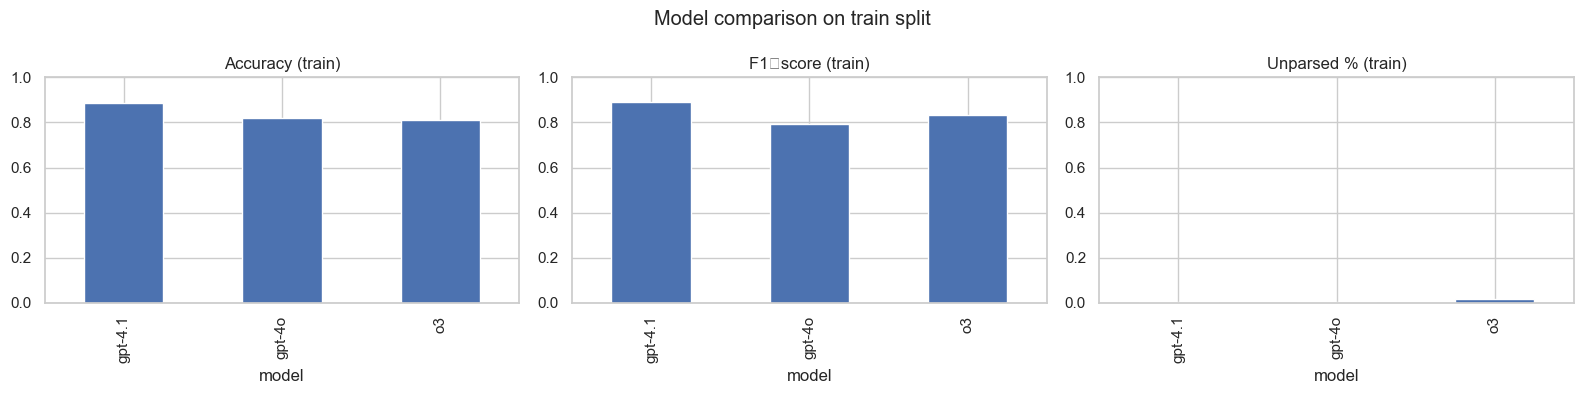

C:\Users\MILORTIE\AppData\Local\Temp\ipykernel_20920\2094331698.py:23: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\MILORTIE\Git repositories\padAIwan\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


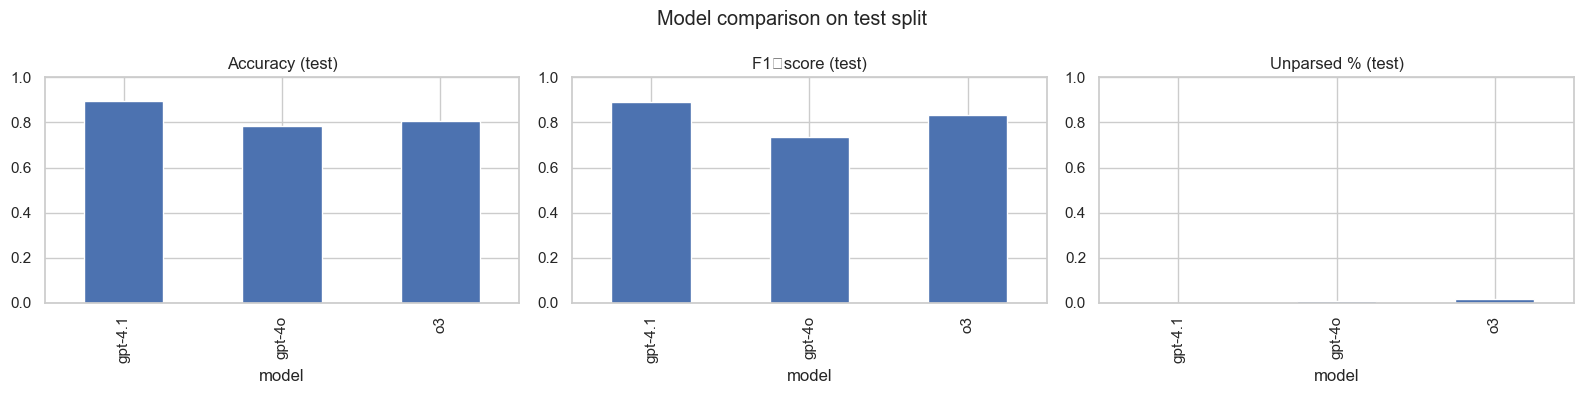

In [7]:
# ╔════════════════════════════════════════════════╗
# ║ Cell 5 – Visualise binary metrics 📊           ║
# ╚════════════════════════════════════════════════╝
for split in ("train", "test"):
    subset = metrics_cls_df.xs(split, level="split")
    if subset.empty:
        continue

    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    subset["accuracy"].plot(kind="bar", ax=axes[0])
    axes[0].set_title(f"Accuracy ({split})")
    axes[0].set_ylim(0, 1)

    subset["f1"].plot(kind="bar", ax=axes[1])
    axes[1].set_title(f"F1‑score ({split})")
    axes[1].set_ylim(0, 1)

    (subset["n_unparsed"] / subset["n_total"]).plot(kind="bar", ax=axes[2])
    axes[2].set_title(f"Unparsed % ({split})")
    axes[2].set_ylim(0, 1)

    plt.suptitle(f"Model comparison on {split} split")
    plt.tight_layout()
    plt.show()

In [ ]:
# ╔════════════════════════════════════════════════╗
# ║ Cell 6 – Extra-field scoring 🏷️               ║
# ╚════════════════════════════════════════════════╝
extra_metrics = []
fields = [
    ("domain_pred",       "domain_gt",       "domain"),
    ("dmf_stage_pred",    "dmf_stage_gt",    "dmf_stage"),
    ("decision_type_pred","decision_type_gt","decision_type"),
    ("bipoc_pred",        "bipoc_gt",        "bipoc"),
    ("indigenous_pred",   "indigenous_gt",   "indigenous"),
    ("sex_pred",          "sex_gt",          "sex"),
    ("gender_pred",       "gender_gt",       "gender")
]

for model, split_dict in all_predictions.items():
    for split, df in split_dict.items():

        # evaluate only items predicted as "included"  
        include_rows = df["pred_class"] == "included"

        # do not evaluate items for which ground truth label is 'included' but other ground truth fields are None
        if fields:
            conditions = [df["ground_truth"] == "included"]
            for field in fields:
                conditions.append(df[field[1]].isna())
            exclude_rows = pd.concat(conditions, axis=1).all(axis=1)
            df_inc = df[include_rows & ~exclude_rows].copy()
        else:
            df_inc = df[include_rows].copy()

        if df_inc.empty:
            continue

        for pcol, tcol, name in fields:
            
            # exclude rows where ground_truth label is "included" and value in tcol equals None
            excl = (df_inc["ground_truth"] == "included") & df_inc[tcol].isna()

            if (~excl).sum() > 0:
                acc = accuracy_score(df_inc.loc[~excl, tcol].fillna(''), df_inc.loc[~excl, pcol].fillna(''))
                f1 = f1_score(df_inc.loc[~excl, tcol].fillna(''), df_inc.loc[~excl, pcol].fillna(''), average='macro')
            else:
                acc = float("nan")
                f1 = float("nan")

            extra_metrics.append(
                {
                    "model"   : model,
                    "split"   : split,
                    "field"   : name,
                    "n_scored": (~excl).sum(),
                    "accuracy": round(acc, 3),
                    "f1"      : round(f1, 3),
                }
            )

# ---- pivot & pretty-print ---- #
a_extra = pd.DataFrame(extra_metrics)
if not a_extra.empty:
    pivot_acc = a_extra.pivot(index=["model", "split"], columns="field", values="accuracy")
    pivot_acc = pivot_acc[["domain", "dmf_stage", "decision_type", "bipoc", "indigenous", "sex", "gender"]]
    print('Accuracy:')
    display(pivot_acc.style.format("{:.3f}"))
    pivot_f1 = a_extra.pivot(index=["model", "split"], columns="field", values="f1")
    pivot_f1 = pivot_f1[["domain", "dmf_stage", "decision_type", "bipoc", "indigenous", "sex", "gender"]]
    print('F1‑score:')
    display(pivot_f1.style.format("{:.3f}"))
else:
    print("Cannot score extra fields.")

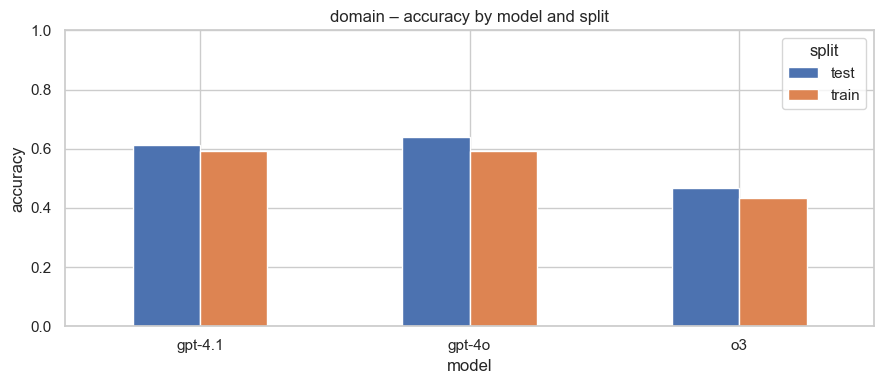

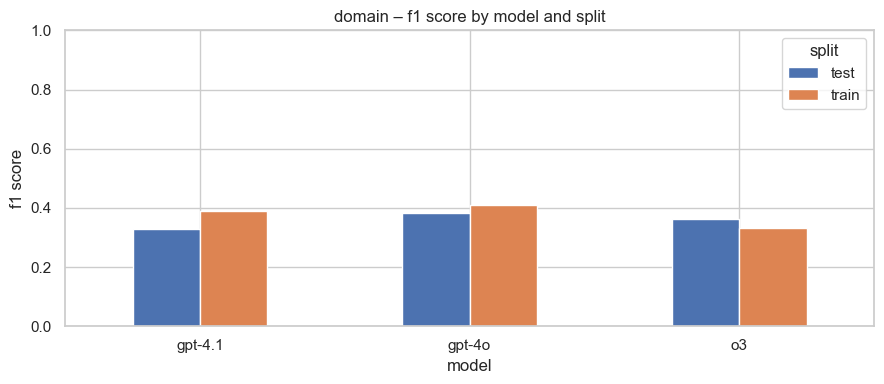

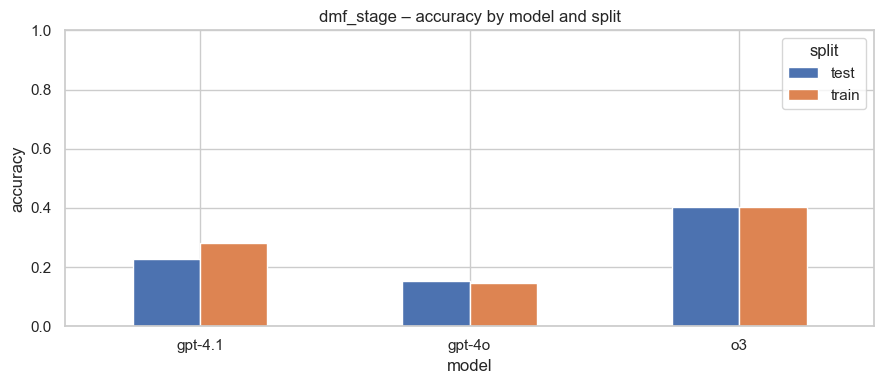

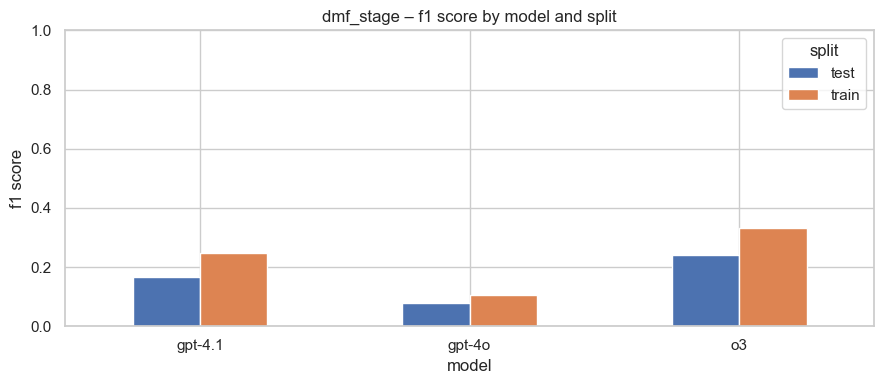

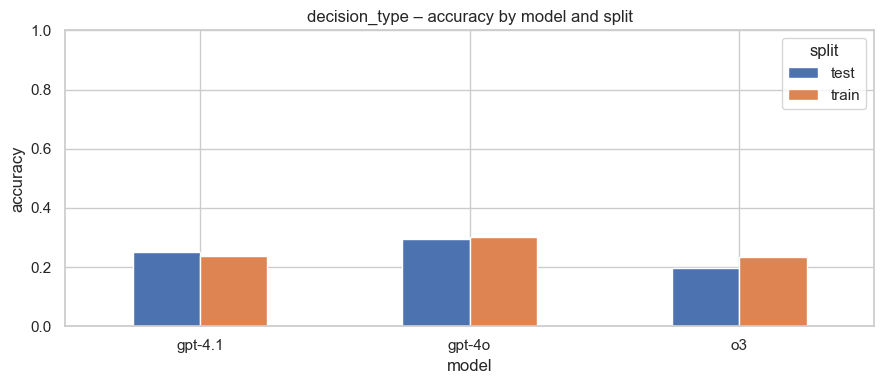

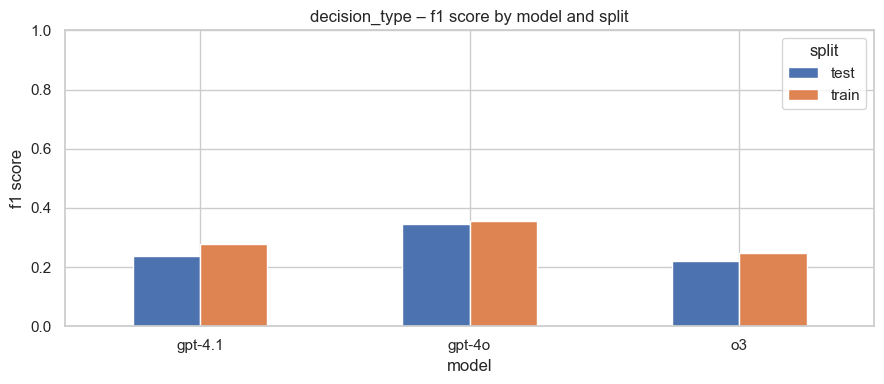

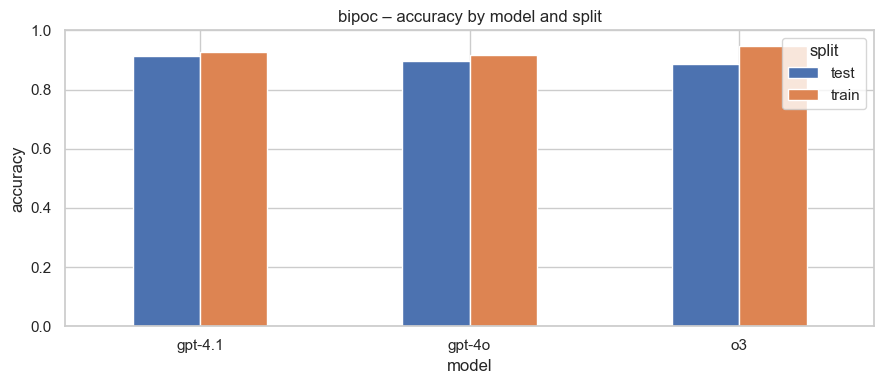

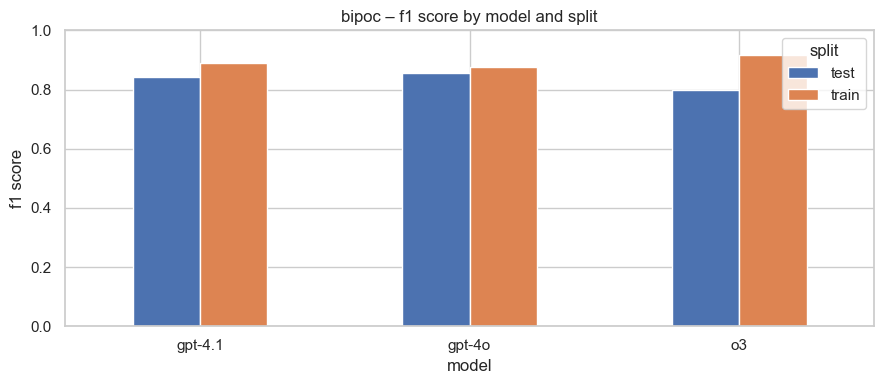

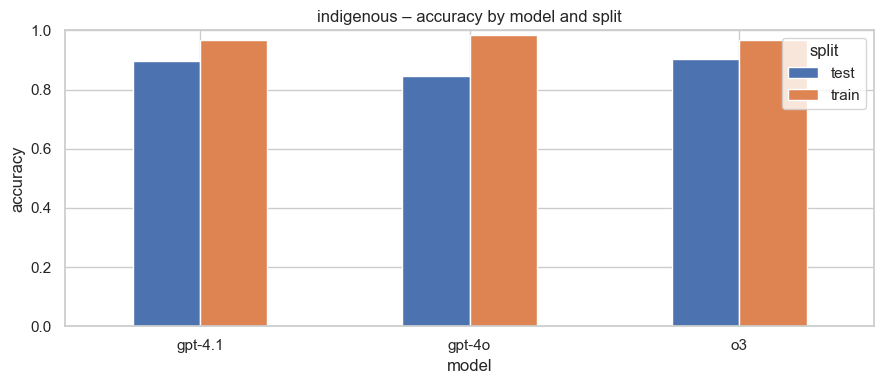

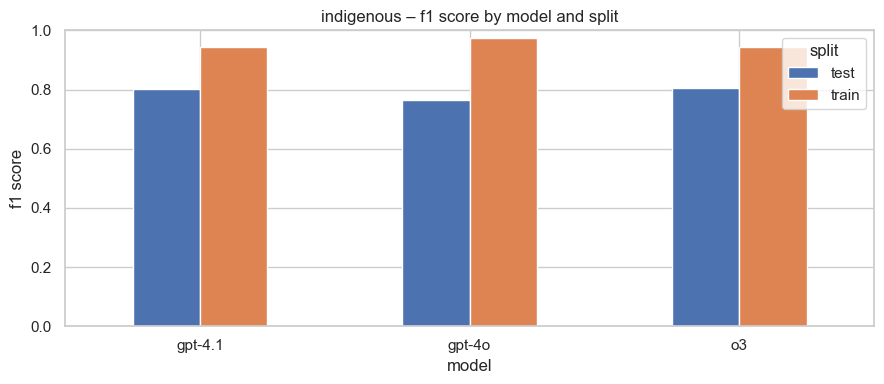

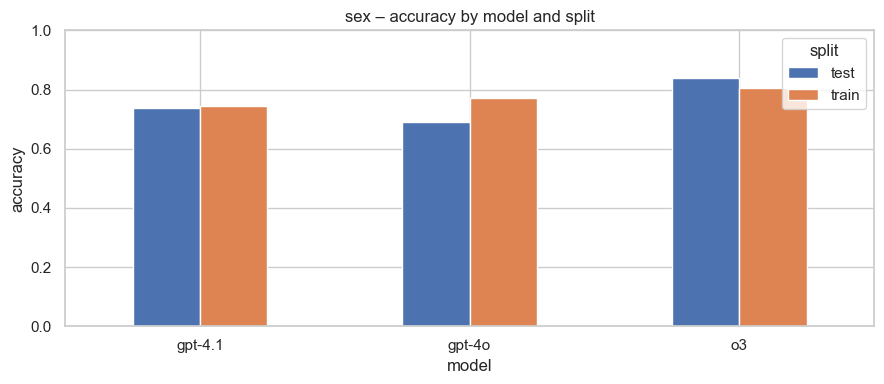

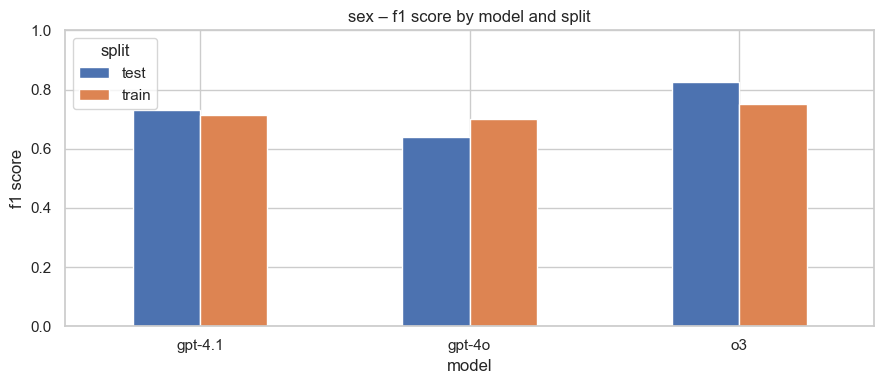

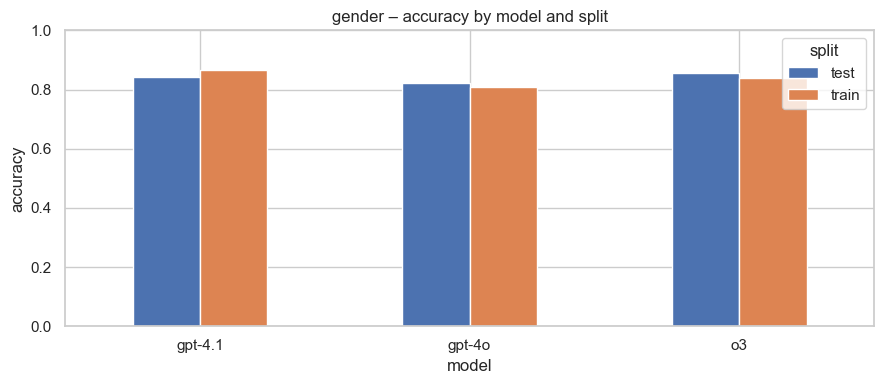

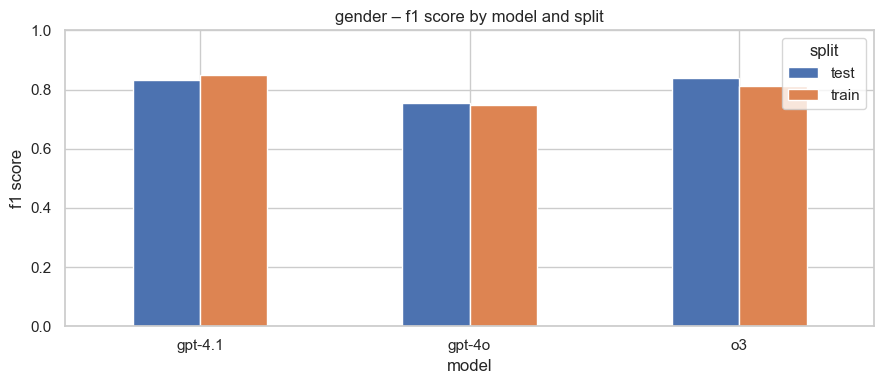

In [9]:
# ╔══════════════════════════════════════════════════════════════╗
# ║ Cell 7 – Visualise extra-field accuracy and f1 score 📊🏷️   ║
# ╚══════════════════════════════════════════════════════════════╝
if not a_extra.empty:
    for field in ["domain", "dmf_stage", "decision_type", "bipoc", "indigenous", "sex", "gender"]:
        fig, ax = plt.subplots(figsize=(9, 4))
        subset_acc = a_extra[a_extra["field"] == field].pivot(
            index="model", columns="split", values="accuracy"
        )
        subset_acc.plot(kind="bar", ax=ax, rot=0)  # one bar-group per model
        ax.set_title(f"{field} – accuracy by model and split")
        ax.set_ylabel("accuracy")
        ax.set_xlabel("model")
        ax.set_ylim(0, 1)
        ax.legend(title="split")
        plt.tight_layout()
        plt.show()

        fig2, ax2 = plt.subplots(figsize=(9, 4))
        subset_f1 = a_extra[a_extra["field"] == field].pivot(
            index="model", columns="split", values="f1"
        )
        subset_f1.plot(kind="bar", ax=ax2, rot=0)  # one bar-group per model
        ax2.set_title(f"{field} – f1 score by model and split")
        ax2.set_ylabel("f1 score")
        ax2.set_xlabel("model")
        ax2.set_ylim(0, 1)
        ax2.legend(title="split")
        plt.tight_layout()
        plt.show()
else:
    print("No extra-field metrics to plot.")


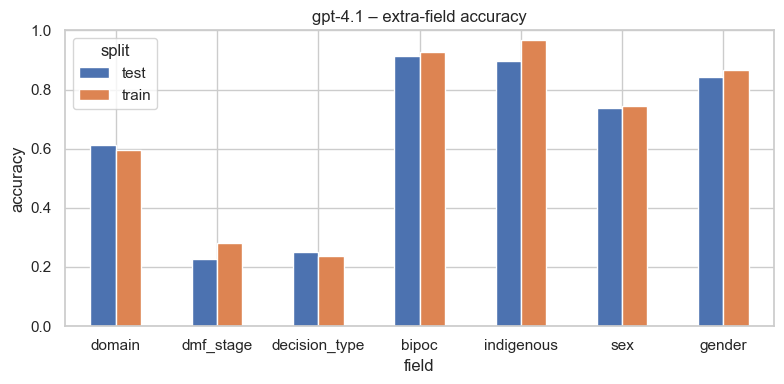

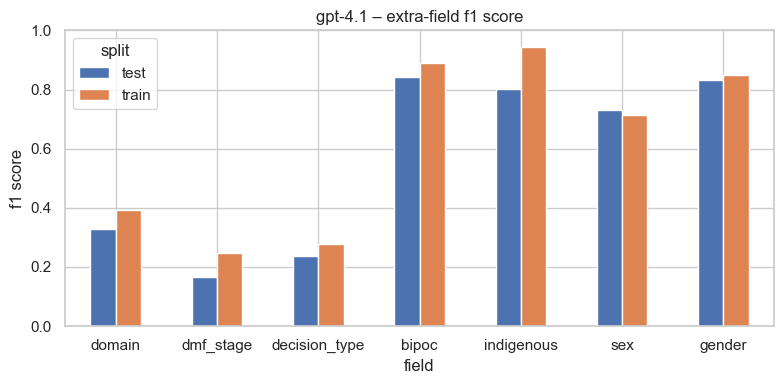

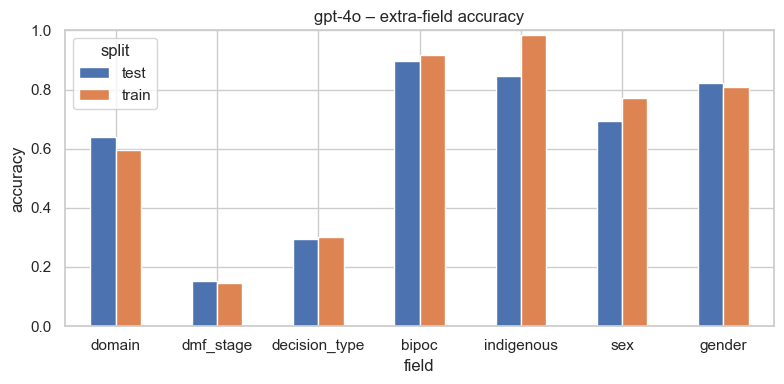

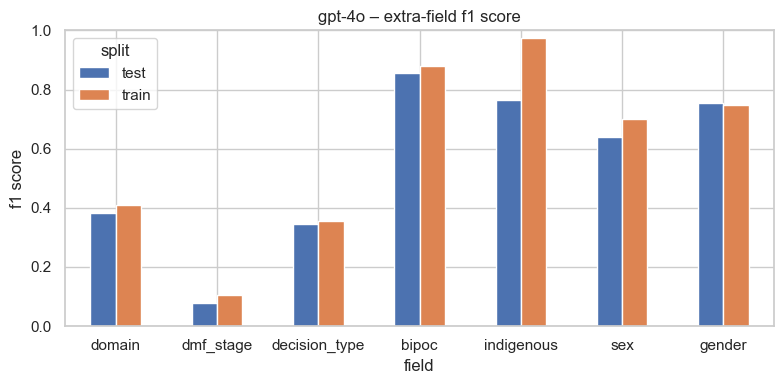

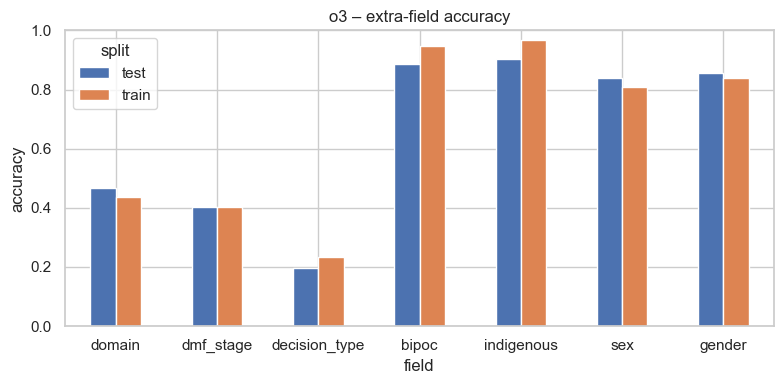

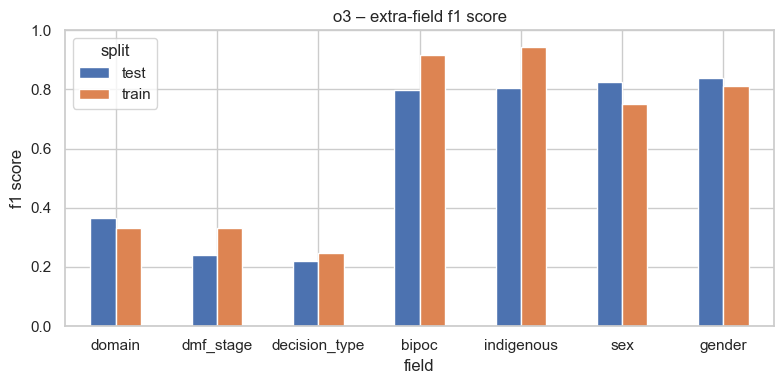

In [10]:
# ╔═════════════════════════════════════════════════════════════╗
# ║ Cell 8 – Per-model feature accuracy and f1 score 📊         ║
# ╚═════════════════════════════════════════════════════════════╝
if not a_extra.empty:
    for model_name in a_extra["model"].unique():
        fig, ax = plt.subplots(figsize=(8, 4))
        subset_acc = (
            a_extra[a_extra["model"] == model_name]
            .pivot(index="field", columns="split", values="accuracy")
            .reindex(["domain", "dmf_stage", "decision_type", "bipoc", "indigenous", "sex", "gender"])
        )
        subset_acc.plot(kind="bar", ax=ax, rot=0)
        ax.set_title(f"{model_name} – extra-field accuracy")
        ax.set_ylabel("accuracy")
        ax.set_xlabel("field")
        ax.set_ylim(0, 1)
        ax.legend(title="split")
        plt.tight_layout()
        plt.show()

        fig2, ax2 = plt.subplots(figsize=(8, 4))
        subset_f1 = (
            a_extra[a_extra["model"] == model_name]
            .pivot(index="field", columns="split", values="f1")
            .reindex(["domain", "dmf_stage", "decision_type", "bipoc", "indigenous", "sex", "gender"])
        )
        subset_f1.plot(kind="bar", ax=ax2, rot=0)
        ax2.set_title(f"{model_name} – extra-field f1 score")
        ax2.set_ylabel("f1 score")
        ax2.set_xlabel("field")
        ax2.set_ylim(0, 1)
        ax2.legend(title="split")
        plt.tight_layout()
        plt.show()
else:
    print("No extra-field metrics to plot.")

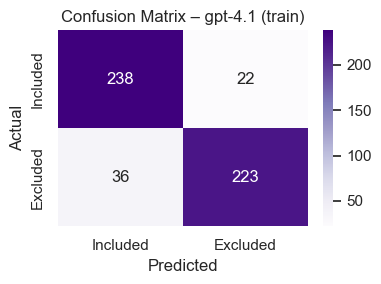

Classification report for gpt-4.1 (train)
              precision    recall  f1-score   support

    excluded      0.910     0.861     0.885       259
    included      0.869     0.915     0.891       260

    accuracy                          0.888       519
   macro avg      0.889     0.888     0.888       519
weighted avg      0.889     0.888     0.888       519



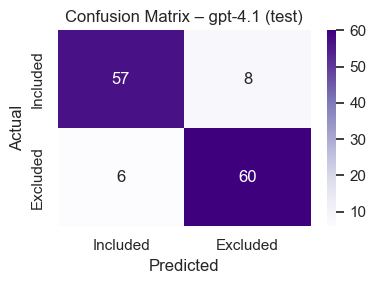

Classification report for gpt-4.1 (test)
              precision    recall  f1-score   support

    excluded      0.882     0.909     0.896        66
    included      0.905     0.877     0.891        65

    accuracy                          0.893       131
   macro avg      0.894     0.893     0.893       131
weighted avg      0.893     0.893     0.893       131



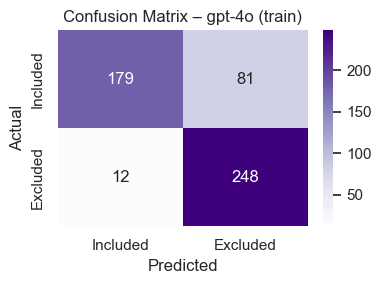

Classification report for gpt-4o (train)
              precision    recall  f1-score   support

    excluded      0.754     0.954     0.842       260
    included      0.937     0.688     0.794       260

    accuracy                          0.821       520
   macro avg      0.845     0.821     0.818       520
weighted avg      0.845     0.821     0.818       520



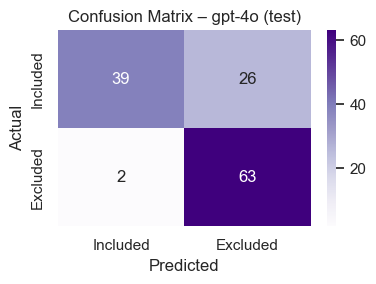

Classification report for gpt-4o (test)
              precision    recall  f1-score   support

    excluded      0.708     0.969     0.818        65
    included      0.951     0.600     0.736        65

    accuracy                          0.785       130
   macro avg      0.830     0.785     0.777       130
weighted avg      0.830     0.785     0.777       130



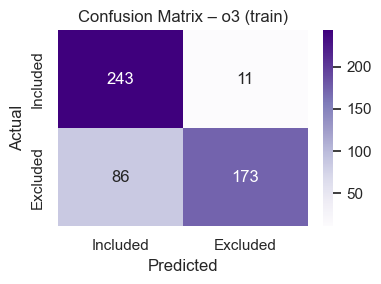

Classification report for o3 (train)
              precision    recall  f1-score   support

    excluded      0.940     0.668     0.781       259
    included      0.739     0.957     0.834       254

    accuracy                          0.811       513
   macro avg      0.839     0.812     0.807       513
weighted avg      0.840     0.811     0.807       513



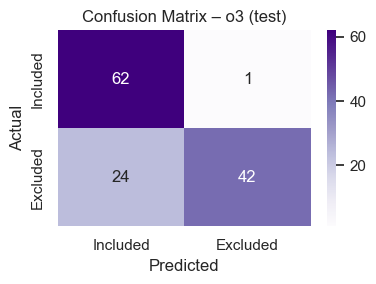

Classification report for o3 (test)
              precision    recall  f1-score   support

    excluded      0.977     0.636     0.771        66
    included      0.721     0.984     0.832        63

    accuracy                          0.806       129
   macro avg      0.849     0.810     0.801       129
weighted avg      0.852     0.806     0.801       129



In [11]:
# ╔════════════════════════════════════════════════╗
# ║ Cell 9 – Confusion matrices for binary task 🔲 ║
# ╚════════════════════════════════════════════════╝
for model, split_dict in all_predictions.items():
    for split, df in split_dict.items():
        parsable = df[df["pred_class"].isin(["included", "excluded"])]
        if parsable.empty:
            continue

        y_true = parsable["ground_truth"]
        y_pred = parsable["pred_class"]

        cm = confusion_matrix(y_true, y_pred, labels=["included", "excluded"])
        plt.figure(figsize=(4, 3))
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Purples",
            xticklabels=["Included", "Excluded"],
            yticklabels=["Included", "Excluded"],
        )
        plt.title(f"Confusion Matrix – {model} ({split})")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        plt.show()

        print(f"Classification report for {model} ({split})")
        print(classification_report(y_true, y_pred, digits=3))

In [12]:
# ╔═════════════════════════════════════════════════╗
# ║ Cell 10 - Automated Free‑text field evaluation  ║
# ╚═════════════════════════════════════════════════╝
import os
import re
import json
from pathlib import Path
import pandas as pd
from dotenv import load_dotenv
from openai import AzureOpenAI
from tqdm.auto import tqdm

# load Azure settings
load_dotenv()   # expects ENDPOINT_URL, AZURE_OPENAI_API_KEY, DEPLOYMENT_NAME, AZURE_OPENAI_API_VERSION
client = AzureOpenAI(
    api_key        = os.getenv("AZURE_OPENAI_API_KEY"),
    azure_endpoint = os.getenv("ENDPOINT_URL"),
    api_version    = os.getenv("AZURE_OPENAI_API_VERSION", "2025-01-01-preview"),
)
DEPLOYMENT_NAME = os.getenv("DEPLOYMENT_NAME")

# regex to strip code fences
fence_re = re.compile(r"^```(?:json)?\s*|\s*```$", flags=re.MULTILINE)

ft_metrics = []
outputs_root = Path.cwd() / "outputs"

for model_dir in outputs_root.iterdir():
    if not model_dir.is_dir():
        continue
    model = model_dir.name

    for split in ("train", "test"):
        preds_dir = model_dir / split / "predictions"
        if not preds_dir.exists():
            continue
        preds = sorted(preds_dir.glob("*.json"))

        for jf in tqdm(preds, desc=f"eval free-text {model} {split}"):
            rec = json.loads(jf.read_text(encoding="utf-8"))
            gt  = rec["ground_truth"]
            pr  = rec["prediction"]

            # require both truth and prediction to be 'Included'
            cls_pred = pr.get("classification","")
            cls_truth = gt.get("classification","")
            if not (isinstance(cls_pred, str) and cls_pred.strip().lower()=="included"):
                continue
            if not (isinstance(cls_truth, str) and cls_truth.strip().lower()=="included"):
                continue

            # extract ground-truth free-text fields
            aud_gt = gt.get("audience","") or ""
            meth_gt = gt.get("methodology","") or ""
            sz_raw = gt.get("sample_size", None)
            sz_gt = str(sz_raw).strip() if sz_raw not in (None, "") else ""
            idfac_gt = gt.get("identity_factors_gt", "") or ""

            # skip if all truth fields are blank
            if not any([aud_gt.strip(), meth_gt.strip(), sz_gt, idfac_gt.strip()]):
                continue

            # extract predicted free-text fields
            aud_pr = pr.get("audience","") or ""
            meth_pr = pr.get("methodology","") or ""
            sz_pr = str(pr.get("sample_size","")).strip()
            idfac_pr = pr.get("Identity_Factors", "") or ""

            prompt = f"""
You are an evaluator of free-text fields. Compare these pairs:

Ground truth Audience: {aud_gt}
Predicted Audience: {aud_pr}

Ground truth Methodology: {meth_gt}
Predicted Methodology: {meth_pr}

Ground truth Sample Size: {sz_gt}
Predicted Sample Size: {sz_pr}

Ground truth Identity Factors: {idfac_gt}
Predicted Identity Factors: {idfac_pr}

Be lenient and forgiving:
- Audience is correct if the core demographic appears in the predicted text even with extra qualifiers
- Methodology is correct if it’s semantically equivalent or more specific
- Sample Size is correct if numeric values match ignoring formatting (e.g. "n=20" vs "20")
- Identity Factors is correct if core identity considerations in ground-truth appear in the prediction even with extra qualifiers

Reply in JSON format like this:

{{
  "audience_correct": 0_or_1,
  "methodology_correct": 0_or_1,
  "sample_size_correct": 0_or_1
  "identity_factors_correct": 0_or_1
}}
"""

            # call LLM with up to 5 retries for valid JSON
            comp = {"audience_correct": None, "methodology_correct": None, "sample_size_correct": None, "identity_factors_correct": None}
            for _ in range(5):
                resp = client.chat.completions.create(
                    model=DEPLOYMENT_NAME,
                    messages=[
                        {"role":"system","content":"You are a helpful assistant that evaluates the similarity of pairs of free-text fields and responds in JSON format."},
                        {"role":"user",  "content":prompt}
                    ],
                    temperature=0
                )
                text = fence_re.sub("", resp.choices[0].message.content.strip())
                try:
                    comp = json.loads(text)
                    break
                except json.JSONDecodeError:
                    continue

            ft_metrics.append({
                "model": model,
                "split": split,
                "id":    jf.stem,
                "audience_gt":        aud_gt,
                "audience_pred":      aud_pr,
                "audience_correct":   comp.get("audience_correct", None),
                "methodology_gt":     meth_gt,
                "methodology_pred":   meth_pr,
                "methodology_correct":comp.get("methodology_correct",None),
                "sample_size_gt":     sz_gt,
                "sample_size_pred":   sz_pr,
                "sample_size_correct":comp.get("sample_size_correct", None),
                "identity_factors_gt": idfac_gt,
                "identity_factors_pred": idfac_pr,
                "identity_factors_correct": comp.get("identity_factors_correct", None),
            })

# build DataFrame
df_ft = pd.DataFrame(ft_metrics)

# save side‑by‑side Excel per model/split
for (model, split), group in df_ft.groupby(["model", "split"]):
    out_dir = outputs_root / model / split
    out_dir.mkdir(parents=True, exist_ok=True)
    file_path = out_dir / f"free_text_eval_{model}.xlsx"
    group[[
        "id",
        "audience_gt","audience_pred","audience_correct",
        "methodology_gt","methodology_pred","methodology_correct",
        "sample_size_gt","sample_size_pred","sample_size_correct",
        "identity_factors_gt","identity_factors_pred","identity_factors_correct"
    ]].to_excel(file_path, index=False)

# display summary pivot
if not df_ft.empty:
    summary = (
        df_ft
        .melt(
            id_vars=["model","split","id"],
            value_vars=["audience_correct","methodology_correct","sample_size_correct","identity_factors_correct"],
            var_name="field",
            value_name="correct"
        )
        .groupby(["model","split","field"])
        .agg(n_scored=("correct","size"), accuracy=("correct","mean"))
        .reset_index()
    )
    display(
        summary
        .pivot(index=["model","split"], columns="field", values="accuracy")
        .style.format("{:.3f}")
    )
else:
    print("No Included records with free-text truth to evaluate")

c:\Users\MILORTIE\Git repositories\padAIwan\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
eval free-text gpt-4.1 train:  46%|████▌     | 238/521 [03:50<04:33,  1.03it/s]


KeyboardInterrupt: 